# Feature detection and description

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Understanding features
Corners are basically cosiderted to be good features in an image as wherever patch is moved, it looks different  
How do we find them? Finding these image features is called "feature detection".  
Once we have found features, we should be able to find  the same in the other images. Expressing features is called "feature description".

## Harris corner detection
### theory
To detect the corner, following function $E(u, v)$ is maximized.  
$$
E(u, v) = \sum_{x, y} w(x, y)~[I(x+u, y+v) - I(x,y)]^2
$$
after some processes:
$$
E(u, v) \approx [u~~v]~M\left[\begin{array}{c} u \\ v \\ \end{array}\right]
$$
$$
M = \sum_{x, y}w(x, y)~\left[\begin{array}{c} I_xI_x~~I_xI_y \\ I_xI_y~~I_yI_y \\ \end{array}\right]
$$
Whether the region is corner or not is determined by following $R$:
$$
R = det(M) - k(tr(M))^2
$$
$k$ is free parameter.
- If |R| is small, the region is flat.
- If R < 0, the region is edge.
- If R is large, the region is corner.

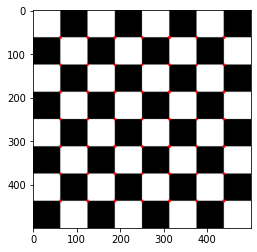

In [9]:
filename = 'inputs/chessboard.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
dst = cv2.dilate(dst, None)

img[dst > 0.01 * dst.max()] = [255, 0, 0]

plt.imshow(img)
plt.show()

### Corner with subpixel accuracy

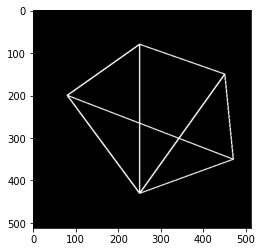

In [18]:
filename = 'inputs/chessboard2.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
dst = cv2.dilate(dst, None)
ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
dst = np.uint8(dst)

# find centroids
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)

# Now draw them
res = np.hstack((centroids, corners))
res = np.int0(res)
img[res[:, 1], res[:, 0]] = (255, 0, 0)
img[res[:, 3], res[:, 2]] = (0, 255, 0)

plt.imshow(img)
plt.show()

`cv2.connectedComponentsWithStats(dst)` returns:
- nlabels: number of labels
- labels: 2D array whose size is same to input image and whose element is label number
- stats: a bounding box and size of objects
- centroids: center of gravity of each object

`cv2.cornerSubPix(img, corners, winSize, zeroSize, criteria)` refines the corners detected with sub-pixel accuracy.
- corners: initial coordinates of the input corners
- winSize: half of the side length of the search window. (1, 1) means 3 x 3 window
- zeroZone: half of the size of the dead region
- criteria: criteria for termination of the iterative process of corner refinement.

## Shi-Tomasi corner detector & good features to track
Harris corner detector was given by:
$$
R = \lambda_1 \lambda_2 - k(\lambda_1 + \lambda_2)^2
$$
Shi-Tomasi proposed:
$$
R = min(\lambda_1, \lambda_2)
$$
If $R$ is greater than a threshold value, it is considered as a corner.

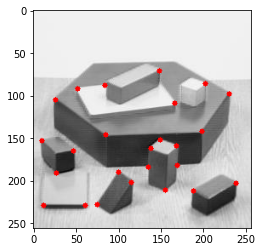

In [21]:
img = cv2.imread('inputs/simple.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray, 25, 0.01, 10)
corners = np.int0(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 3, 255, -1)
    
plt.imshow(img)
plt.show()

`cv2.goodFeaturesToTrack(img, maxCorners, qualityLevel, minDistance)` detect corners with Shi-Tomasi method.
- maxCorners: If more corners than this value are found, the strongest corners are returned.
- qualityLevel: minimal accepted quality of image corners. If the best corner has the quality measure=1500 and the qualityLevel=0.01, quality measure less than 15 are rejected.
- minDistance: minimum possible Euclideandistance between the returned corners.

## Introduction to SIFT (Scale-Invariant Feature Transform)
### Theory
Harris corner is rotation-invariant but not scale-invariant. SIFT is used to scale-invariant feature.
1. A number of Difference of Gaussian (DoG) are obtained by take the difference between two images, which is gaussian filtered with different $\sigma$. This process is done for different image sizes. Local extrema are searched in DoGs over scale and space. One pixel in an image is compared with its 8 neighbours as well as 9 pixels in next scale and 9 pixels in previous scale (26 total pixels).
1. To get more accurate results, the extrema of small threshold value are removed. DoG has higher respose for edges, edges should be removed. Hessian matrix is used to compute the principal curvature and keypoints larger greater than a threshold are removed.
1. A neighbourhood is taken around the keypoint and the gradient magnitude and direction is calculated in the region. The highest peak in the histogram and peaks over 80% of maximum are detected. In this way an orientation is assigned to each keypoint.
1. 16 x 16 neighbourhodd around the keypoint is taken. It is divided into 16 sub-blocks of 4 x 4 size. For each sub-block, 8 bin orientation histogram is created. In this way 128 dimention feature vector is obtained.
1. Keypoints between two images are matched by identifying their nearest neighbours. In some cases, the second closest-match may be very near to the first because of noise or some other reasons. Ratio of closest-distance to second-closest distance is taken and if it it greater than 0.8, they are rejected.

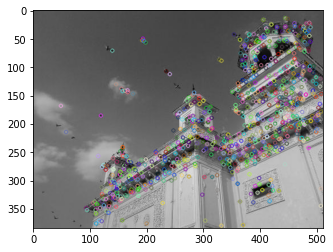

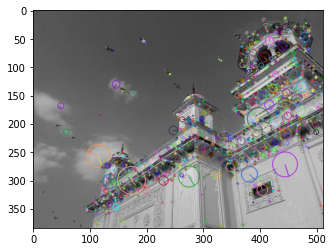

In [8]:
img = cv2.imread('inputs/home.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp = sift.detect(gray, None)

img = cv2.drawKeypoints(gray, kp, img)
plt.imshow(img)
plt.show()

# scale and orientation can be displayed
img = cv2.drawKeypoints(gray, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

In [13]:
# compute the feature
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray, None)

Here, `kp` is a list of [keypoints](https://docs.opencv.org/4.x/d2/d29/classcv_1_1KeyPoint.html) and `des` is a numpy array of shape (num of keypoints, 128).

## Introduction to SURF (Speeded Up Robust Features)
### Theory
SIFT takes time to compute, so speeded-up version SURF is proposed. SURF approximates LoG with Box filter, it has a big advantage that convolution with box filter is easily calculated with the hekp of integral images. Determinant of Hessian matrix is also relied for scale and location.

When computing oriention, SURF uses wavelet responses in horizontal and vertical direction for a neighbourhood 6 x 6.After given adequate gaussian weights, wavelet responses are plotted in a space. The dominant orientation is estimated by calculating the sum of all responses.

For feature description, SURF uses wavelete responses in horizontal and vertical direction. A neighbourhood of size 20 x 20 is taken around the keypoint and is divided into 4 x 4 subregions. For each subregion, horizontal and  vertical wavelet responses are taken and vector is formed like this: $v = (\sum d_x, \sum d_y, \sum | d_x |, \sum | d_y |)$. This gives SURF feature with 64 dimensions. It is extended 128 dimensions if calculation is separatedly according to sign. Another important improvement is the use of sign of Laplacian (trace of Hessian Matrix).

In [7]:
img = cv2.imread('inputs/fly.png', 0)

surf = cv2.xfeatures2d.SURF_create(400)
kp, des = surf.detectAndCompute(img, None)
print(len(kp))

# Raise threshold of Hessian matrix
surf.hessianThreshold = 50000
kp, des = surf.detectAndCompute(img, None)
print(len(kp))

img2 = cv2.drawKeypoints(img, kp, None, (255, 0, 0), 4)
plt.imshow(img2)
plt.show()

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv_contrib/modules/xfeatures2d/src/surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'


In [ ]:
# use U-SURF, which doesn't calculate orientation
print(surf.upright)
surf.upright = True

kp = surf.detect(img, None)
img2 = cv2.drawKeypoints(img, kp, None, (255, 0, 0), 4)
plt.imshow(img2)
plt.show()

In [ ]:
# finally, chenge the dimension of feature
print(surf.descroptorSize())
print(surf.extended)

surf.extended = True
kp, des = surf.detectAndCompute(img, None)
print(surf.descriptorSize())
print(des.shape)

## FAST algorithm for feature detection
### Theory
1. Select a pixel $p$ in the image and lets its intensity be $I_p$.
1. Select an appropriate threshold value t.
1. Consider a circle its circumference is 16 pixels and the center is a interest pixel.
1. $p$ is a corner if all $n$ pixels in the circle are brighter than $I_p + t$, or all darker than $I_p - t$.
1. A high-speed test is conducted to exclude a large number of non-corners. First, the values of four pixels on the circumference are tested if they are brighter or darker. If $p$ is a corner, at lease three of these must all be brighter than $I_p + t$ or darker than $I_P - t$. If neither of these is the case, then $p$ cannot be a corner. This test is applied to all pixels in the circle if the pixel meets the conditons.

### Introduce machine learning to a corner detector
Above method perfomes well but there are some weaknesses:
- It doesn't reject many candidates for n < 12
- The choice of pixels is not optimal because its efficiency depends on ordering of the questions and distribution of corners.
- Results of high-speed tests are thrown away
To address these problems, machine learning approach is used.
1. Select a set of images for training.
1. Run Fast algorithm in every images to find feature points.
1. For every feature point, store the 16 pixels around it as a feature vector $P$.
1. Each pixel $x$ in these 16 pixels is represented as:
$$
S_{p\rightarrow x} = 
    \begin{cases}
        {d~~(I_{p\rightarrow x} \leq I_p - t)} \\
        {s~~(I_p - t \leq  I_{p\rightarrow x} \leq I_p + t)} \\
        {b~~(I_p + t \leq I_{p\rightarrow x})}
    \end{cases}
$$
1. Depending on above states, $P$ is subdivided into 3 subsets, $P_d, P_s, P_b$.
1. Define $K_p$, which is true if $p$ is a corner and false if not.
1. Use the ID3 algorithm (decision tre  classifier) to estimate $K_p$ from each subset.
1. This process is recursively applied to all the subsets until its entropy is zero.

### Non-maximal Suppression
Above method has another problem that multiple features are detected adjacetnt to one another. It is resolved by following process:
1. Compute the sum of absolute difference between $p$ and 16 surrounding pixel values ($V$) for all the detected feature points.
1. Consider two adjacent keypoints and compute their $V$.
1. Discard the one with lower $V$.

### FAST in OpenCV

Threshold:  10
nonmaxSuppression:  True
neighborhood:  2
Total keypoints with nonmaxSuppresion 430


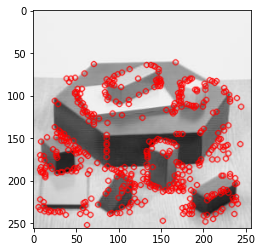

In [4]:
img = cv2.imread('inputs/simple.jpeg', 0)

fast = cv2.FastFeatureDetector_create()
kp = fast.detect(img, None)
img2 = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0))

# print all default params
print("Threshold: ", fast.getThreshold())
print("nonmaxSuppression: ", fast.getNonmaxSuppression())
print("neighborhood: ", fast.getType())
print("Total keypoints with nonmaxSuppresion", len(kp))

plt.imshow(img2)
plt.show()

Total keypoints without nonmaxSupression 1562


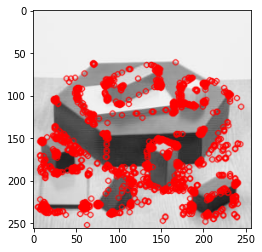

In [5]:
# disable nonmaxSuppression
fast.setNonmaxSuppression(0)
kp = fast.detect(img, None)
img3 = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0))

print("Total keypoints without nonmaxSupression", len(kp))

plt.imshow(img3)
plt.show()

## BRIEF (Binary Robust Independent Elementary Features)
SIFT uses 128-dim vector but it needs larger memory. All these dimensions may not be needed for actual matching and it can be compressed. BRIEF provides a shortcut to find the binary strings directly without finding descriptors. It builds a set of $n_d~(x, y)$ location pairs.　Then comparing pixel values for each pair. If two pixels $p$ and $q$ meet the condition $I(p)~<~I(q)$, return 1, else return 0. This is applied for all the $n_d$ location pairs.

BRIEF is only a feature descriptor, doesn't find the features.

### STAR (CenSurE) in OpenCV
STAR is a feature detector derived from CenSurE. While CenSurE uses polygons like squares, hexagons and octagons to approach a circle, STAR emulates a circle with 2 overlapping squares: 1 upright and 1 45-degree rotated.

In [6]:
img = cv2.imread('inputs/simple.jpeg', 0)

# init STAR detector
star = cv2.xfeatures2d.StarDetector_create()

# init BRIEF extractor
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

kp = star.detect(img, None)
kp, des = brief.compute(img, kp)

print(brief.descriptorSize())
print(des.shape)

32
(33, 32)


## ORB (Oriented FAST and Roated BRIEF)
ORB is came from "OpenCV Labs" and able to use freely while SIFT and SURF are patented.

ORB is basically a fusion of FAST feature detector and BRIEF descriptor.
- FAST is used to find keypoints and Harris corner is applied to find top N points among them.
- FAST doesn't compute the orientation, BRIEF modify like this:
    - Intensity weighted centroid of the patch located corner at center is computed.
    - The direction of the vector from this corner to centroid gives the orientation.
    - Moments in a circular region of radius $r$ are computed to improve the rotation variance. $r$ is the size of the patch.
- BRIEF performs poorly with rotation, so ORB improves it. $2 \times n$ matrix $S$, which contains the coordinates of a feature set of $n$ binary tests at location $(x_i, y_i)$ is defined. Its rotation matrix is searched with the orientation of patch, and rotates the S to get rotated version $S_\theta$.
- ORB construct a lookup table of precomputed BRIEF patterns. If the feature orientation $\theta$ is consistent across views, the correct set of points $S_\theta$ is used to compute its descriptor.
- ORB runs a greedy search among all possible binary tests to find the ones that have both high variance and means close to 0.5.
- For descriptor matching, multi-probe LSH is used.

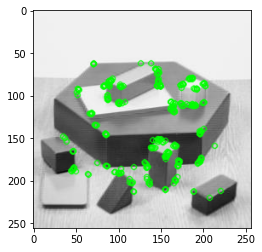

In [14]:
img = cv2.imread("inputs/simple.jpeg", 0)

# init ORB detector
orb = cv2.ORB_create()

# find the keypoints
kp = orb.detect(img, None)

# compute the descriptors
kp, des = orb.compute(img, kp)

img2 = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)
plt.imshow(img2)
plt.show()

## Feature matching
### Basics of Brute-Force matcher
Brute-Force matcher simply takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. The closest one is returned.

`cv2.BFMatcher(normType, crossCheck)` creates the BFMatcher object.
normType: `cv2.NORM_L1`, `cv2.NORM_L2` (for SIFT, SURF) and `cv2.NORM_HAMMING` (for ORB, BRIEF)  
crossCheck: default is false. If true, it comfirms whether two features in both sets should match each other.  

Next, `BFMatcher.match()` or `BFMatcher.knnmatch()` to return best match. Former return one match, latter returns k best matches.  

Finally, `cv.drwaMatches()` is used to draw the matches.

### Brute-Force matching with ORB descriptors

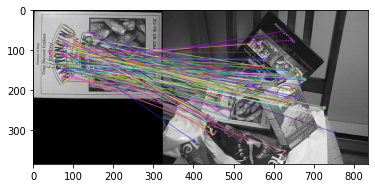

In [5]:
img1 = cv2.imread('inputs/box.png', 0)
img2 = cv2.imread('inputs/box_in_scene.png', 0)

# init ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# match descriptors
matches = bf.match(des1, des2)
matches = sorted(matches, key= lambda x: x.distance)  # best matches come to front

img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)

plt.imshow(img3)
plt.show()

### Matcher object is...
a list of DMatch objects. DMatch object has:
- DMatch.distance: distance between descriptors. The lower, the better it is.
- DMatch.trainIdx: index of the descriptor in reference data.
- DMatch.queryIdx: index of the descriptor in query data.
-DMatch.imgIdx: Index of the train image.

### Brute-Force matching with SIFT descriptors and ratio test

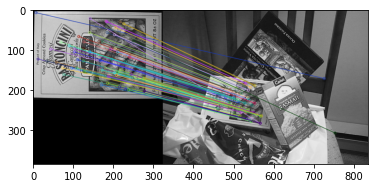

In [8]:
img1 = cv2.imread('inputs/box.png', 0)
img2 = cv2.imread('inputs/box_in_scene.png', 0)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])
        
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)
plt.imshow(img3)
plt.show()

## FLANN based matcher
FLANN stands for Fast Library for Approximate Nearest Neighbors. This library works faster than BFMatcher for large datasets.

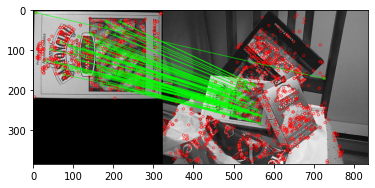

In [10]:
img1 = cv2.imread('inputs/box.png', 0)
img2 = cv2.imread('inputs/box_in_scene.png', 0)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# create a mask to draw only good matches
matchesMask = [[0, 0] for _ in range(len(matches))]

# ratio test
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]
        
draw_params = dict(matchColor = (0, 255, 0), singlePointColor = (255, 0, 0),
                                    matchesMask = matchesMask, flags = 0)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
plt.imshow(img3)
plt.show()

## Feature matching and homography to find objects
`cv2.findHomography()` returns the perspective transformation from the set of points in both the images. Then `cv2.perspectiveTransform()` is used to find the object.

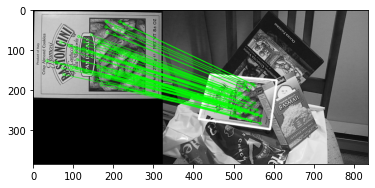

In [14]:
MIN_MATCH_COUNT = 10

img1 = cv2.imread('inputs/box.png', 0)
img2 = cv2.imread('inputs/box_in_scene.png', 0)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
        
# If enough matches are found, the locations of matched keypoints in both the images are extracted.
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    
    matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    
    height, width = img1.shape
    pts = np.float32([[0, 0], [0, height-1], [width-1, height-1], [width-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, matrix)
    
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d / %d" % (len(good), MIN_MATCH_COUNT))
    matchesMask = None
    
# Finally, draw inliers (if failed, only matching keypoints)
draw_params = dict(matchColor = (0, 255, 0), singlePointColor = None,
                                    matchesMask = matchesMask, flags = 2)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.imshow(img3, "gray")
plt.show()